In [1]:
# export XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
import jax
from jax.scipy.sparse.linalg import cg
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.numpy.linalg import lstsq
import matplotlib.pyplot as plt

import natgrad.mlp as mlp
from natgrad.domains import Square
from natgrad.domains import SquareBoundary, Polygon
from natgrad.integrators import RandomIntegrator, DeterministicIntegrator, EvolutionaryIntegrator
from natgrad.derivatives import laplace
from natgrad.inner import model_laplace, model_identity
from natgrad.gram import gram_factory, nat_grad_factory, nat_grad_factory_generic
from natgrad.utility import grid_line_search_factory
from natgrad.plotting import plot_2d_func, plot_2d_funcs
from natgrad.linalg import sherman_morrison
#from jaxopt import LevenbergMarquardt
from jaxopt.linear_solve import solve_cg
from natgrad.levenberg_marquardt import LevenbergMarquardt
from natgrad.logger import EventTracker

jax.config.update("jax_enable_x64", True)

## Setup

Levenberg-Marquardt is a regularised Gauss-Newton.
$$
    \theta_{k+1} = \theta_k - (\lambda \cdot\mathrm{diag}(A_k^TA_k) + A_k^TA_k)^{-1}A_k,
$$
with $A_k = JF(\theta_k) \in R^{|param|\times |batch|}$. To Find the inverse, we employ conjugate gradient, which means we have to implement the matrix-vector product:
$$
    (\lambda\cdot \mathrm{diag}(A^TA) + A^TA) v
$$
The above can be implemented as:



In [2]:
# random seed
seed = 2
freq = 1.

# domains
interior = Square(1.) #Polygon(jnp.array([[0,0], [1,0], [0,1]])) # S
boundary = interior.boundary()

# integrators
key = random.PRNGKey(seed)
interior_integrator = RandomIntegrator(interior, key, 20)
boundary_integrator = RandomIntegrator(boundary, key, 20)
eval_integrator = RandomIntegrator(interior, key, 200)

# model
activation = lambda x : jnp.tanh(x)
layer_sizes = [2, 64, 64, 1]
model = mlp.mlp(activation)
v_model = vmap(model, (None, 0))

# 

# solution
@jit
def u_star(xy): return jnp.sin(freq * jnp.pi * xy[0]) * jnp.sin(freq * jnp.pi * xy[1])

# rhs
@jit
def f(xy):
    return 2. * (freq * jnp.pi)**2 * u_star(xy)


# trick to get the signature (params, v_x) -> v_residual
_res = lambda params: laplace(lambda x: model(params, x))
res_interior = lambda params, x: (_res(params)(x) + f(x))
v_res_interior =  jit(vmap(res_interior, (None, 0)))

res_bdry = lambda params, x: model(params, x)
v_res_bdry = jit(vmap(res_bdry, (None, 0)))


# loss
@jit
def interior_loss(params):
    return interior_integrator(lambda x: v_res_interior(params, x)**2)

@jit
def boundary_loss(params):
    return boundary_integrator(lambda x: v_res_bdry(params, x)**2)

@jit
def loss(params):
    return interior_loss(params) + boundary_loss(params)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Training


In [3]:
print("Switching to ENG \n")
name = "state_{solver}"

params = mlp.init_params(layer_sizes, random.PRNGKey(seed))
params, unflatten = jax.flatten_util.ravel_pytree(params)
flatten = lambda x: jax.flatten_util.ravel_pytree(x)[0]

error = lambda x: model(params, x) - u_star(x)
v_error = vmap(error, (0))
v_error_abs_grad = vmap(lambda x: jnp.dot(grad(error)(x), grad(error)(x))**0.5)

def l2_norm(f, integrator):
    return integrator(lambda x: (f(x))**2)**0.5    

def residuals(params):
    params = unflatten(params)
    boundary_res_pts = vmap(res_bdry, (None, 0))(params, boundary_integrator._x) / boundary_integrator._N
    interior_res_pts = vmap(res_interior, (None, 0))(params, interior_integrator._x) / interior_integrator._N
    return jnp.concatenate([boundary_res_pts, interior_res_pts])

class Callback():
    def __init__(self, name="state_LM", save_every_n=50, update_every_n=50, verbose=True):
        self.logger = EventTracker()
        self.iter = 0
        self.name = name
        self.update_every_n = update_every_n
        self.save_every_n = save_every_n
        self.loss = []
        
    def __call__(self, params, delta, loss, natgrad=None):
        self.loss.append(loss)
        if self.iter % self.save_every_n == 0:
            data = {"gram": None, 
                    "params": params, 
                    "update": delta,
                    "param_new": params,
                    "loss": self.loss,
                    "natgrad": natgrad,
                    "error": None}#l2_norm(vmap(lambda x: model(params, x) - u_star(x)), (0))}
        
            jnp.save(f"/home/emastr/phd/NaturalGradientTraining/data/{self.name}_{self.iter}", data)
            
        if self.iter % self.update_every_n == 0:
            interior_integrator.update()
            boundary_integrator.update()
            
        print(f"step: {self.iter}, loss: {self.loss[-1]:.2e}, time:{self.logger.events['update'].time_mean}", end="\r")
        self.iter += 1
        return None
        
callback = Callback()

def cg_solver(A, b, *args, **kwargs):
    kwargs["maxiter"] = 10
    return solve_cg(A, b, *args, **kwargs)

presets = {"natgrad_svd": {"materialize_jac": "full", "solver": lstsq, "dampling_parameter": 0.},
           "levmarq_svd": {"materialize_jac": "full", "solver": lstsq, "dampling_parameter": 1.},
           "levmarq_cg_full": {"materialize_jac": "full", "solver": cg_solver, "dampling_parameter": 1e-8},
           "levmarq_cg_semi": {"materialize_jac": "semi", "solver": cg_solver, "dampling_parameter": 1e-8},
           "levmarq_cg_jvps": {"materialize_jac": "none", "solver": cg_solver, "dampling_parameter": 1e-8}}

logger = EventTracker()
optim = LevenbergMarquardt(residuals, maxiter=1, damping_parameter=1e-4, materialize_jac='full', solver=cg_solver, scale_invariant=True)
out = optim.run(params)
for i in range(101):
    
    callback.logger.start_event("update")
    out = optim.update(out.params, out.state)
    callback.logger.end_event("update")
    
    callback(unflatten(out.params), out.state.delta, out.state.loss, out.state.delta)
    
params = unflatten(out.params)

Switching to ENG 



NameError: name 'error' is not defined

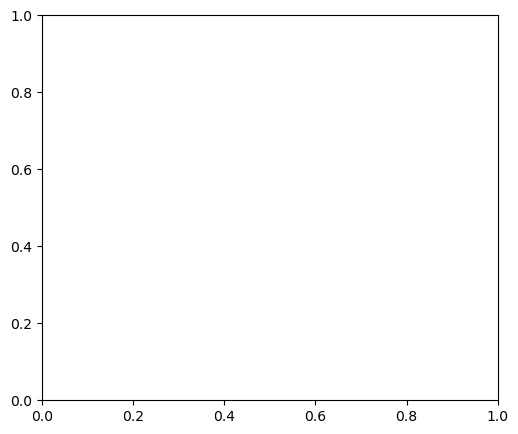

In [ ]:
import matplotlib.pyplot as plt



plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
pmesh = plot_2d_func(vmap(error, (0)), interior)
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 2)
pmesh = plot_2d_func(vmap(u_star, (0)), interior)
plt.colorbar(pmesh)
plt.axis('equal')

plt.subplot(1, 3, 3)
pmesh = plot_2d_func(lambda x: v_model(params, x), interior)
plt.colorbar(pmesh)
plt.axis('equal')

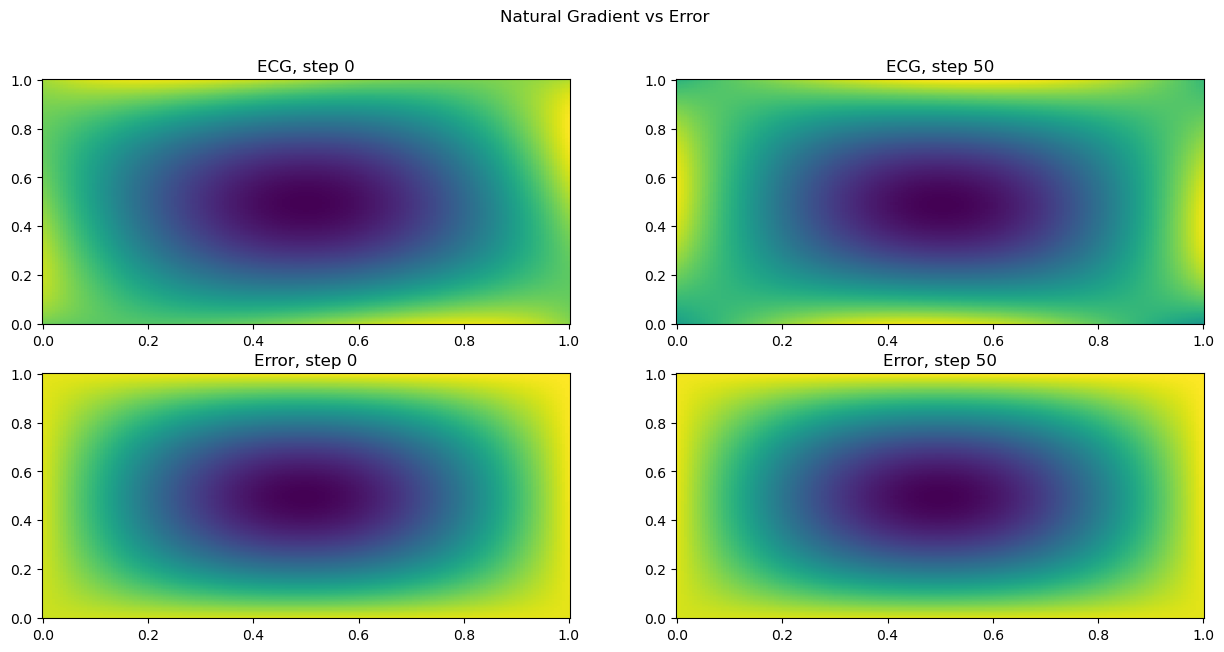

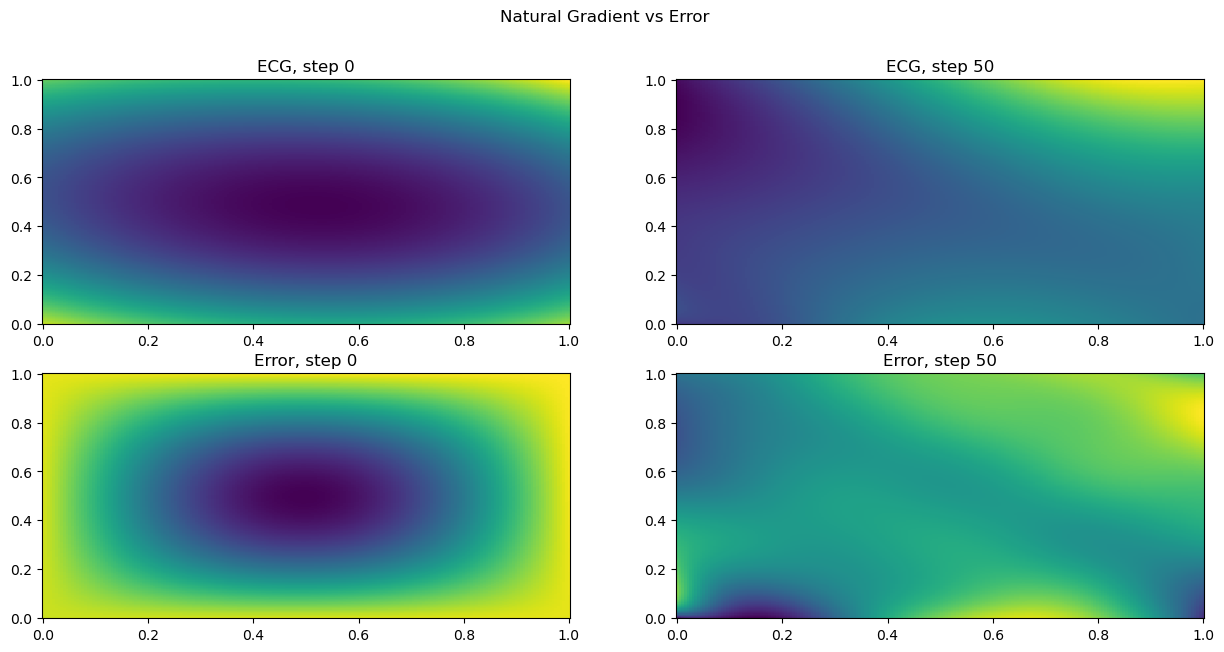

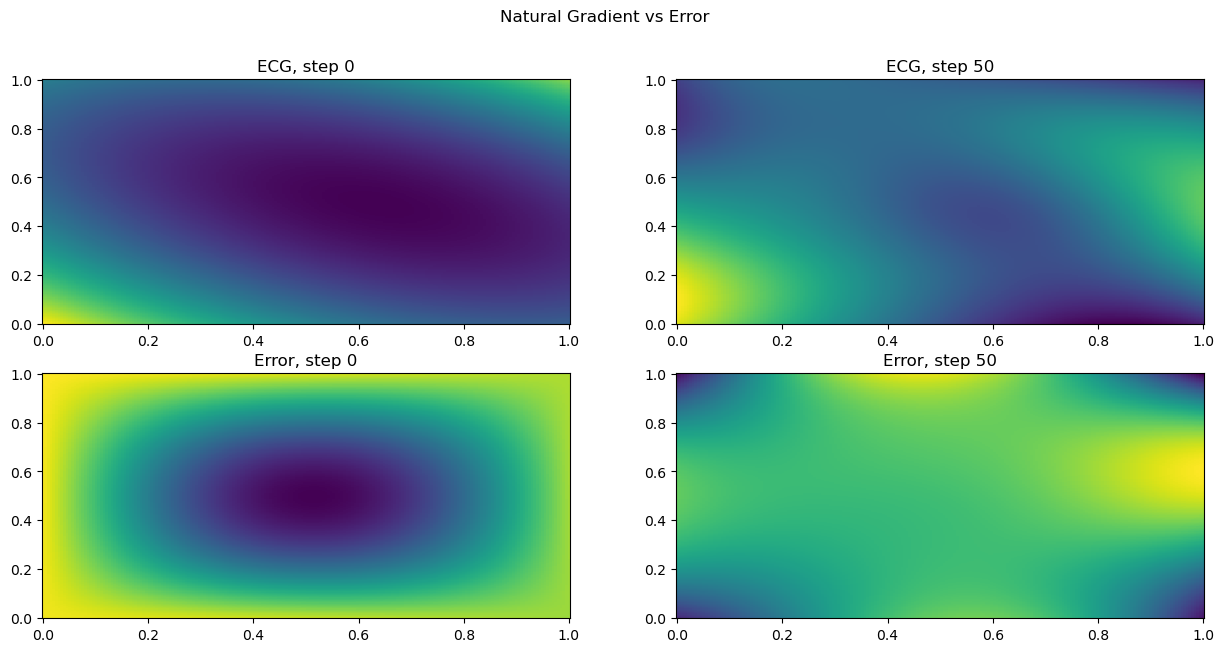

In [4]:
ids = list(range(0, 400, 50))
n = 2#int(jnp.ceil(float(len(ids)) ** 0.5))

def update_step(x, param, natgrad_flat):
    grad_ = jax.flatten_util.ravel_pytree(grad(model, (0))(param, x))[0]
    return jnp.dot(grad_, natgrad_flat)

def wrap(func, *args):
    return jit(vmap(lambda x: func(x, *args), (0)))

for name in ["state_ENG", "state_CG", "state_LM"]:
    step_funcs = []
    error_funcs = []
    for i in range(n):
        data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/{name}_{ids[i]}.npy", allow_pickle=True).item()
        param = data["params"]
        natgrad = jax.flatten_util.ravel_pytree(data["natgrad"])[0]
        natgrad = natgrad if (name != "state_LM") else -natgrad
        error_funcs.append(wrap(lambda x, par: (model(par, x) - u_star(x)), param))
        step_funcs.append(wrap(update_step, param, natgrad))
        
        
    plt.figure(figsize=(15, 7))
    plt.suptitle("Natural Gradient vs Error")
    step_axes = [plt.subplot(2, n, i + 1) for i in range(n)]
    error_axes = [plt.subplot(2, n, n + i + 1) for i in range(n)]
    for i, (sax, eax) in enumerate(zip(step_axes, error_axes)):
        sax.set_title(f"ECG, step {ids[i]}")
        eax.set_title(f"Error, step {ids[i]}")
    plot_2d_funcs(funcs=step_funcs, domain=interior, axList=step_axes, same_vlim=False)
    plot_2d_funcs(funcs=error_funcs, domain=interior, axList=error_axes, same_vlim=False)
    None

[64, 32, 32, 1]


/tmp/ipykernel_96603/350402239.py:75: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n, n, i+1)
/tmp/ipykernel_96603/350402239.py:82: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n, n, i+1)
/tmp/ipykernel_96603/350402239.py:87: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n, n, i+1)


NameError: name 'plot_funcs' is not defined

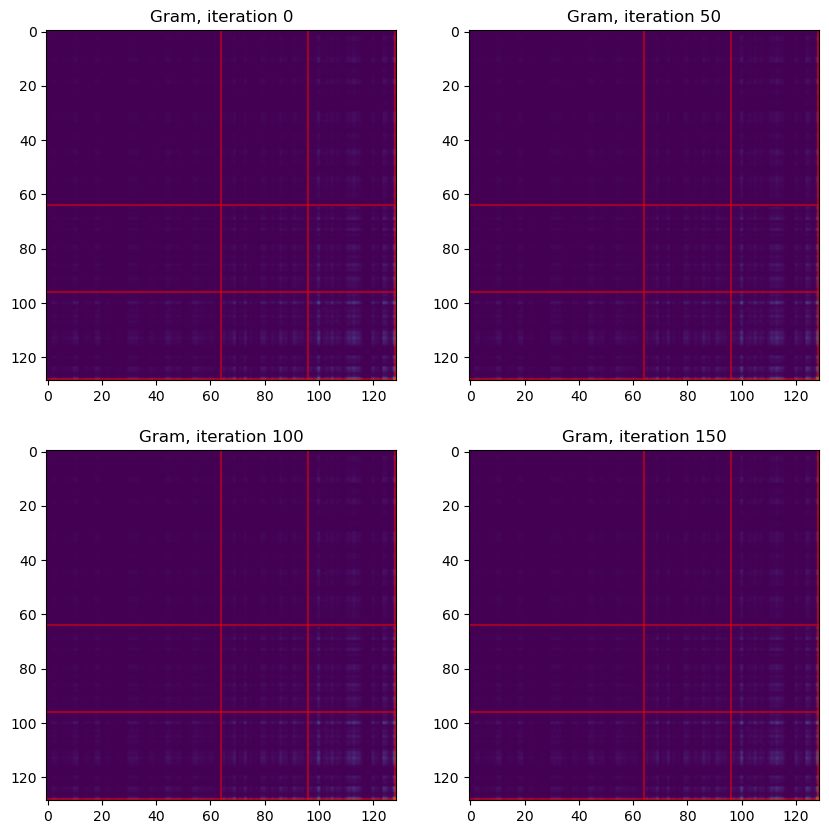

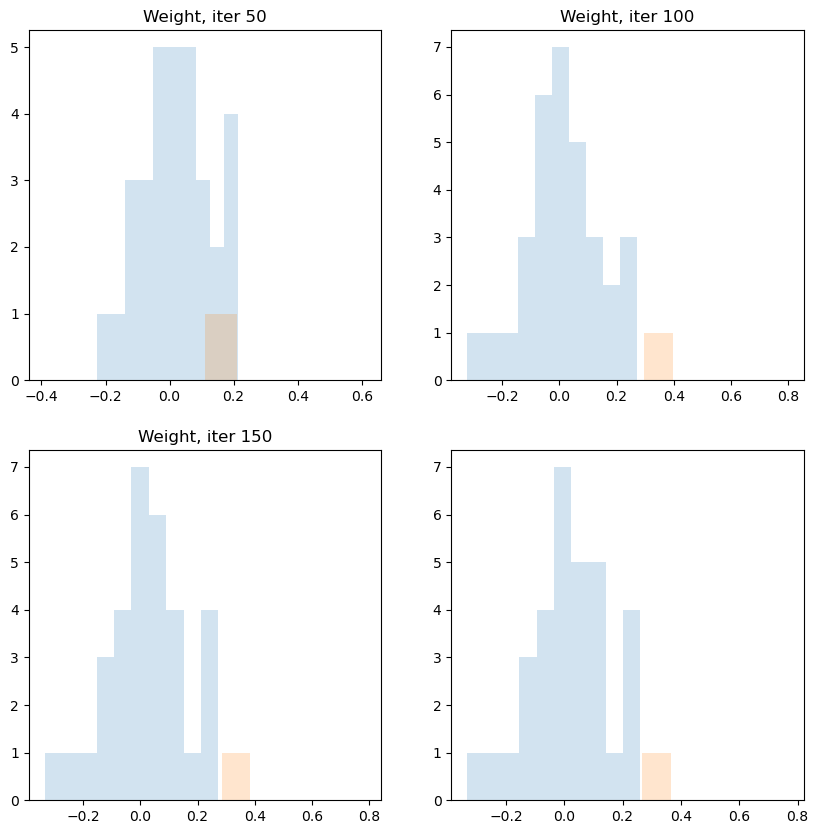

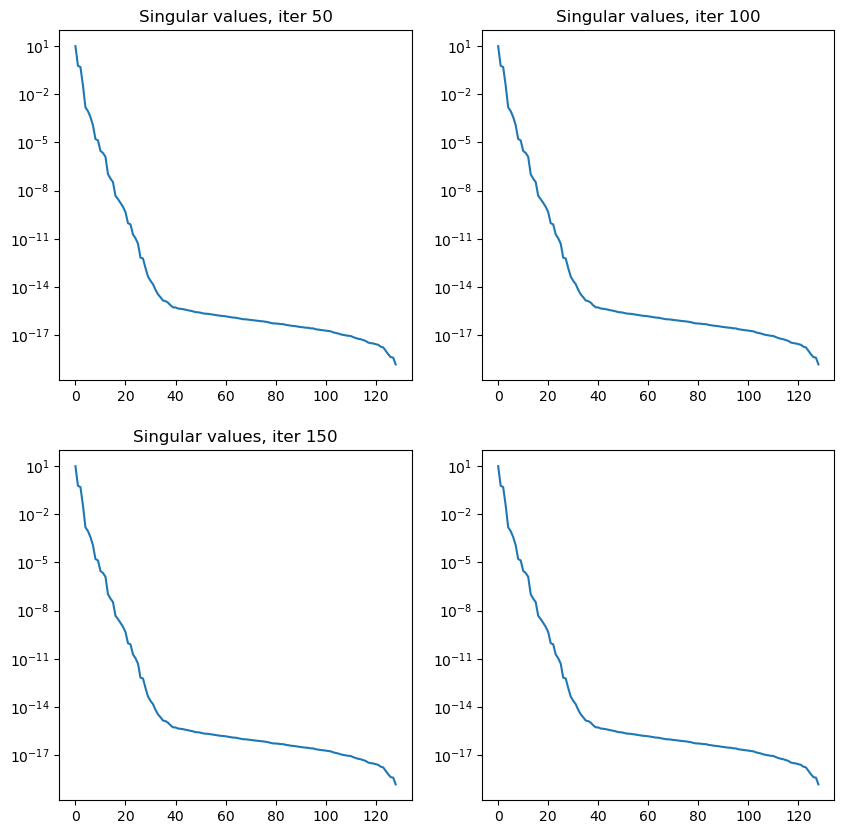

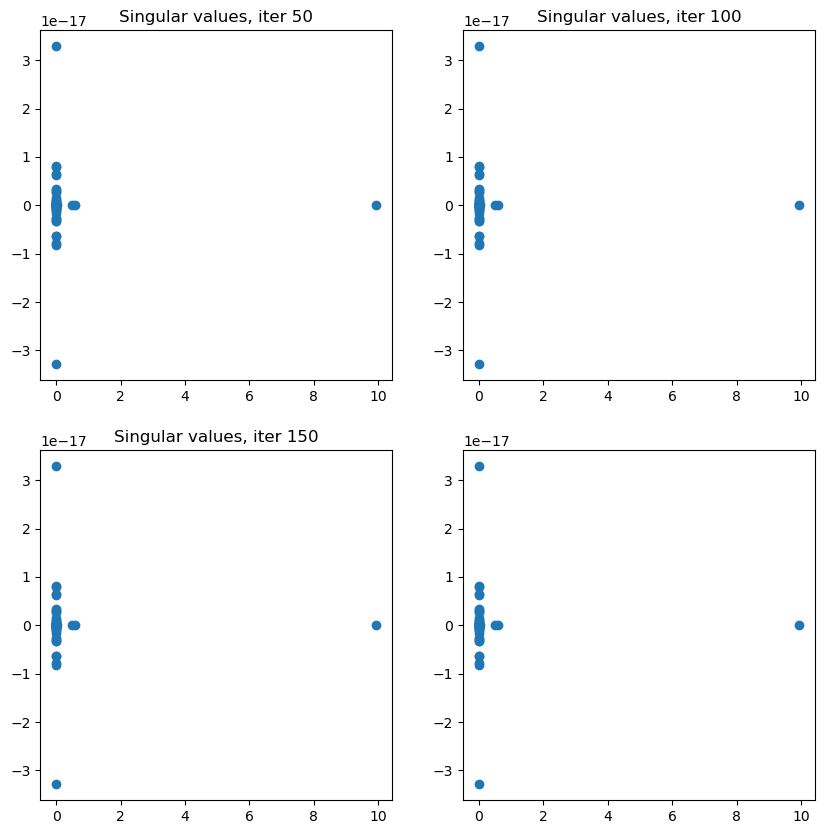

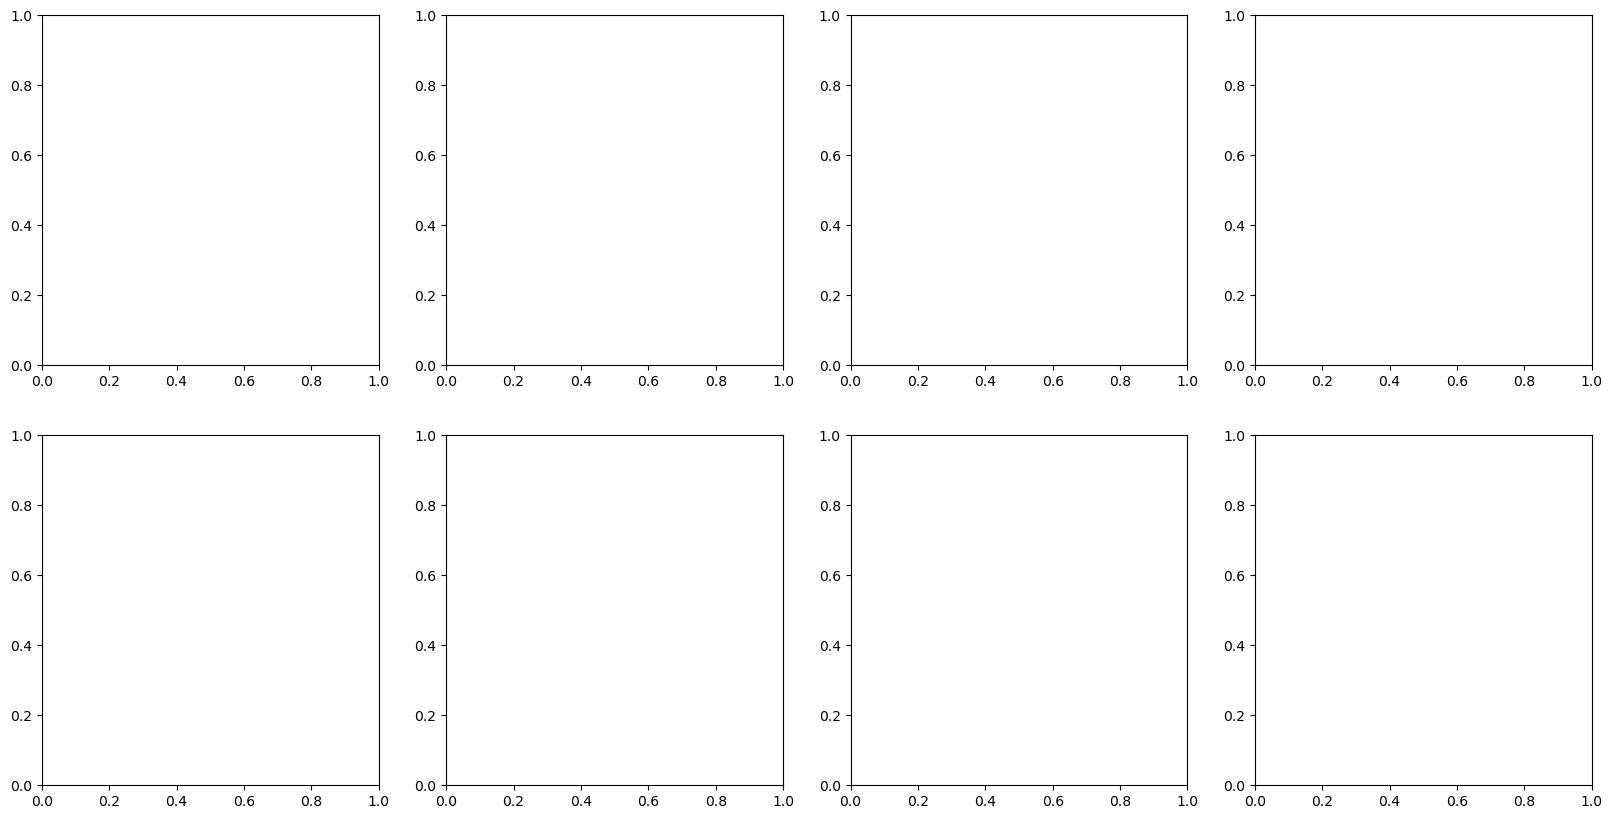

In [6]:
ids = list(range(0, 400, 50))
n = 2#int(jnp.ceil(float(len(ids)) ** 0.5))

plt.figure(figsize=(20, 10))
plt.suptitle="Gramians"

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

plt.figure(figsize=(10, 10))
plt.suptitle="Gramians"

par_nums = []
for p in params: par_nums = par_nums + [p[0].shape[0]*p[0].shape[1]] + [len(p[1])]
print(par_nums)
par_nums = jnp.cumsum(jnp.array(par_nums))

def update_step(x, param, natgrad_flat):
    grad_ = jax.flatten_util.ravel_pytree(grad(model, (0))(param, x))[0]
    return jnp.dot(grad_, natgrad_flat)

prev_par = None
mat = None

plt.figure(1)
step_axes = [plt.subplot(2, n*n, i + 1) for i in range(n*n)]
error_axes =[plt.subplot(2, n*n, n*n + i + 1) for i in range(n*n)]
step_funcs = []
error_funcs = []



for i in range(n*n):
    data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/state_{ids[i]}.npy", allow_pickle=True).item()
    if mat is None:
        mat = data["gram"]
    else:
        alf = 0.0 #(1/i) ** 0.5
        mat = (1 - alf) * mat + alf * data["gram"]
    param = data["params"]
    natgrad = jax.flatten_util.ravel_pytree(data["natgrad"])[0]
    

    
    sing_vals = jnp.linalg.svd(mat, compute_uv=False)
    eigs = jnp.linalg.eigvals(mat)
    
    #plt.figure(1)
    #plt.subplot(2, n*n, i + 1)
    #plot_func(vmap(lambda x: (model(param, x) - u_star(x)), (0)), interior)
    error_axes.append(vmap(lambda x: (model(param, x) - u_star(x)), (0)))
    step_axes.append(lambda x: update_step(x, param, natgrad))
    
    #plt.subplot(2, n*n, n*n + i + 1)
    #plot_func(vmap(lambda x: update_step(x, param, natgrad)), interior)
    
    plt.figure(2)
    plt.subplot(n, n, i+1)
    plt.title(f"Gram, iteration {ids[i]}")
    for j in range(len(par_nums)-1):
        plt.plot([par_nums[j], par_nums[j]], [0, mat.shape[0]], 'red', alpha=.5)
        plt.plot([0, mat.shape[0]], [par_nums[j], par_nums[j]], 'red', alpha=.5)
    plt.imshow(jnp.abs(mat))
    #plt.imshow(jnp.log10(jnp.abs(mat)))
    
    
    plt.figure(3)
    plt.title(f"Weight, iter {ids[i]}")
    plt.subplot(n, n, i+1)
    for p in param:
        plt.hist(p[1].flatten(), alpha=0.2, density=False)
        
        
    plt.figure(4)
    plt.title(f"Singular values, iter {ids[i]}")
    plt.subplot(n, n, i+1)
    plt.semilogy(sing_vals)
    
    plt.figure(5)
    plt.title(f"Singular values, iter {ids[i]}")
    plt.subplot(n, n, i+1)
    plt.scatter(eigs.real, eigs.imag)
    #plt.xlim([-1e-2, 1e-2])
    #plt.ylim([-1e-2, 1e-2])
    
    
plt.figure(1)
plot_funcs(step_funcs, interior, step_axes)
plot_funcs(error_funcs, interior, error_axes)

In [ ]:

optim = LevenbergMarquardt(residuals, maxiter=500, tol=1e-10)

def init(optim, init_params, *args, **kwargs):
    state = optim.init_state(init_params, *args, **kwargs)
    zero_step = optim._make_zero_step(params, state)
    opt_step = optim.update(params, state, *args, **kwargs)
    init_val = (opt_step, (args, kwargs))
    return init_val, zero_step


init_val, zero_step = init(optim, params)
params, state = init_val[0].params, init_val[0].state

for i in range(100):
    step = optim.update(params, state, *init_val[1][0], **init_val[1][1])
    params, state = step.params, step.state
    callback()
    print(f"loss: {step.state.loss}", end="\r")
    
    
params = unflatten(optim.run(params).params)

Array(24.83638861+0.j, dtype=complex128)

In [ ]:
class Callback():
    def __init__(self, name="save_LM", save_every_n=50, update_every_n=50, verbose=True):
        self.iter = 0
        self.name = name
        self.update_every_n = update_every_n
        self.save_every_n = save_every_n
        
    def __call__(self, params, state):
        if self.iter % self.save_every_n == 0:
            data = {"gram": None, 
                    "params": params, 
                    "update": state.delta,
                    "param_new": params,
                    "loss": state.loss,
                    "natgrad": state.delta,
                    "error": None}#l2_norm(vmap(lambda x: model(params, x) - u_star(x)), (0))}
        
            jnp.save(f"/home/emastr/phd/NaturalGradientTraining/data/{self.name}_{self.iter}", data)
            
        if self.iter % self.update_every_n == 0:
            interior_integrator.update()
            boundary_integrator.update()
            
        print(f"step: {self.iter}, loss: {state.loss}", end="\r")
        self.iter += 1
        return None
        
callback = Callback()    

optim = LevenbergMarquardt(residuals, maxiter=1, tol=1e-10)
out = optim.run(params)

for i in range(100):
    out = optim.update(out.params, out.state)
    callback(out.params, out.state)
    
params = unflatten(optim.run(params).params)